# Entrenar un robot utilizant Q-Learning

## Introducció

En aquest notebook, entrenarem un robot perquè trobi la millor ruta per arribar a la seva destinació. Utilitzarem algorsimes genètics per aconseguir-ho. 

Com ja hem vist en altres notebooks, els algoritmes genètics són una tècnica d'optimització inspirada en la selecció natural. En aquest cas, l'objectiu és trobar la millor ruta per arribar a la destinació. Partirem d'una xarxa neuronal ja creada i anirem modificant els pesos per aconseguir la millor ruta.

## Preparar les llibreries

Utilitzarem les llibreries d'`aitk` per aconseguir el nostre objectiu. Començarem instal·lant les llibreries necessàries.

In [14]:
!pip install aitk

In [15]:
from aitk.algorithms.ga import GeneticAlgorithm
from aitk.networks import SimpleNetwork
import aitk.robots as bots
from aitk.robots.utils import distance
from aitk.utils import Grid

import numpy as np

import random

## Algorisme genètic

En aquest problema plantejarem les següents definicions:

- **Gen**: Un gen serà un pes de la xarxa neuronal.
- **Cromosoma**: Un cromosoma serà una xarxa neuronal amb els pesos corresponents. El seu tamany serà el nombre de pesos de la xarxa neuronal.
- **Població**: Una població serà un conjunt de cromosomes.

El mon i el robot seran els mateixos que en el notebook anterior.

Per definir l'algorisme genètic utilitzarem la classe `GeneticAlgorithm` de la llibreria `aitk.algorithms.ga`. Aquesta classe necessita facilita la creació de l'algorisme.

In [25]:
class RobotAG(GeneticAlgorithm):
    def __init__(self, tamany_poblacio):
        self.world = bots.World(240, 150)

        self.world.add_wall("blue", 0, 0, 50, 50)
        self.world.add_wall("blue", 75, 200, 125, 150)
        self.world.add_wall("blue", 150, 0, 200, 50)
        self.world.add_wall("blue", 150, 150, 200, 100)
        self.world.add_wall("blue", 0, 100, 50, 150)

        self.world.add_wall("blue", 100, 25, 105, 125)
        self.world.add_wall("blue", 100, 70, 120, 75)

        self.world.add_bulb("yellow", 125, 130, 1, 30)

        self.robot = bots.Scribbler(x=30, y=80, a=90)
        self.robot.add_device(bots.RangeSensor(width=45,max=20,name="front"))
        self.robot.add_device(bots.RangeSensor(width=45,max=20,position=(6,-6),
                                                a=90,name="left"))
        self.robot.add_device(bots.LightSensor(position=(6, 0), name="light"))

        self.world.add_robot(self.robot)

        self.pos_inicial = (30, 80, 90)

        self.net = SimpleNetwork(3, 5, 2, activation="tanh", optimizer="adam", loss="mse")

        tamany_cromosoma = len(self.net.get_weights(flat=True))

        super().__init__(length=tamany_cromosoma, popSize=tamany_poblacio)

    def make_random_gene(self):
        # Retorna un valor aleatori per a un pes de la xarxa (entre -2 i 2)

        return random.uniform(-2, 2)
    
    def mutate_gene(self, gen):
        # Muta un gen canviant-lo lleugerament

        return gen + random.uniform(-0.5, 0.5)
    
    def fitness(self, chromosome, index=None, poses=None, seconds=180, interrupt=True, real_time=False,
                show=False, show_progress=False, quiet=True):
        # Avalua el cromosoma i retorna el seu valor de fitness

        # Tornem a posar el robot a la posició inicial
        self.world.reset()
        self.robot.set_pose(*self.pos_inicial)
        self.grid = Grid((10, 10), self.world)

        # Establim els pesos de la xarxa
        self.net.set_weights(chromosome)

        # Executem el robot durant 100 segons màxim
        self.world.seconds(
            seconds, self.controller,
            real_time=real_time
        )

        # Calculem el valor de fitness
        score = 0

        if not self.robot.stalled:
            visites = self.grid.analyze_visits()
            sensor_lum = self.robot["light"]
            llum = sensor_lum.get_brightness()

            # Volem que el robot s'aproximi a la llum en els mínims passos possibles
            # Per aixó el valor de fitness serà 1/la distancia a la llum - el temps que ha trigat (escalat  )

            pos_actual = self.robot.get_pose()
            x_actual, y_actual = pos_actual[0], pos_actual[1]

            score = visites * 10 + llum * 100 - self.world.time / 2000
            
        return score

    def controller(self, world):
        # Controlador del robot

        sensor_esquerra = self.robot["left"]
        sensor_davant = self.robot["front"]
        sensor_lum = self.robot["light"]

        dist_esq = sensor_esquerra.get_distance()
        dist_davant = sensor_davant.get_distance()
        llum = sensor_lum.get_brightness()

        inputs = np.array([dist_esq/20, dist_davant/20, llum])
        output = self.net.predict(np.array([inputs]))
        
        out = output[0]

        x, y, a = self.robot.get_pose()
        self.grid.update(x, y)
        self.grid.draw()

        if inputs[-1] > 0.95:
            return True
        else:
            self.robot.move(out[0], out[1])
        
        if self.robot.stalled:
            return True

ag = RobotAG(10)

Random seed set to: 5010696
Genetic algorithm
  Chromosome length: 32
  Population size: 10


In [17]:
ag.world.watch()

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

In [18]:
ag.fitness(ag.make_random_chromosome())


Using random seed: 3434698


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 30.95 x real time


0

In [27]:
%%time
ag.reset()
ag.world.reset()
ag.world.time = 0
bestFound = ag.evolve(
    generations=20, 
    crossover_rate=0.2, 
    mutation_rate=0.6, 
    elite_percent=0.05, 
    seconds=180,
    show=True,
) 

Using random seed: 5010696
Maximum number of generations: 20
  Elite percentage 0.05 (0/10 chromosomes per generation)
  Crossover rate: 0.2 (~2/10 crossovers per generation)
  Mutation rate: 0.6 (~384/320 genes per generation)
Evaluating initial population...
Using random seed: 5010696


  0%|          | 0/1800 [00:00<?, ?it/s]

  3%|▎         | 51/1800 [00:00<00:04, 410.74it/s]


Simulation stopped at: 00:00:05.10; speed 40.23 x real time
Using random seed: 5010696


  1%|▏         | 23/1800 [00:00<00:05, 353.08it/s]


Simulation stopped at: 00:00:02.30; speed 34.05 x real time
Using random seed: 5010696


  2%|▏         | 30/1800 [00:00<00:04, 433.45it/s]


Simulation stopped at: 00:00:03.00; speed 42.09 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:02<00:00, 689.70it/s]


Simulation stopped at: 00:03:00.00; speed 68.92 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 595.22it/s]


Simulation stopped at: 00:03:00.00; speed 59.48 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:02<00:00, 609.38it/s]


Simulation stopped at: 00:03:00.00; speed 60.89 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:02<00:00, 612.14it/s]


Simulation stopped at: 00:03:00.00; speed 61.16 x real time
Using random seed: 5010696


  2%|▏         | 40/1800 [00:00<00:05, 315.39it/s]


Simulation stopped at: 00:00:04.00; speed 30.82 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:02<00:00, 635.67it/s]


Simulation stopped at: 00:03:00.00; speed 63.52 x real time
Using random seed: 5010696


  2%|▏         | 42/1800 [00:00<00:03, 569.79it/s]

Simulation stopped at: 00:00:04.20; speed 55.44 x real time
Done!


  0%|          | 0/20 [00:00<?, ?it/s]

Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 558.71it/s]


Simulation stopped at: 00:03:00.00; speed 55.8 x real time
Using random seed: 5010696


 22%|██▎       | 405/1800 [00:00<00:02, 515.59it/s]


Simulation stopped at: 00:00:40.50; speed 51.38 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 592.32it/s]


Simulation stopped at: 00:03:00.00; speed 59.19 x real time
Using random seed: 5010696


 47%|████▋     | 842/1800 [00:01<00:01, 607.20it/s]


Simulation stopped at: 00:01:24.20; speed 60.63 x real time
Using random seed: 5010696


 10%|█         | 185/1800 [00:00<00:03, 457.12it/s]


Simulation stopped at: 00:00:18.50; speed 45.36 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 580.01it/s]


Simulation stopped at: 00:03:00.00; speed 57.91 x real time
Using random seed: 5010696


 48%|████▊     | 865/1800 [00:01<00:01, 558.80it/s]


Simulation stopped at: 00:01:26.50; speed 55.78 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 562.83it/s]


Simulation stopped at: 00:03:00.00; speed 56.22 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 540.55it/s]


Simulation stopped at: 00:03:00.00; speed 54.02 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 547.43it/s]


Simulation stopped at: 00:03:00.00; speed 54.69 x real time
Generation    1 Best fitness 1.51
Using random seed: 5010696


 11%|█         | 193/1800 [00:00<00:03, 432.58it/s]


Simulation stopped at: 00:00:19.30; speed 42.84 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 529.91it/s]


Simulation stopped at: 00:03:00.00; speed 52.96 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 530.45it/s]


Simulation stopped at: 00:03:00.00; speed 53.0 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 490.58it/s]


Simulation stopped at: 00:03:00.00; speed 48.99 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 521.33it/s]


Simulation stopped at: 00:03:00.00; speed 52.09 x real time
Using random seed: 5010696


  7%|▋         | 131/1800 [00:00<00:04, 403.68it/s]


Simulation stopped at: 00:00:13.10; speed 39.85 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 511.92it/s]


Simulation stopped at: 00:03:00.00; speed 51.14 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 508.38it/s]


Simulation stopped at: 00:03:00.00; speed 50.79 x real time
Using random seed: 5010696


 12%|█▏        | 207/1800 [00:00<00:02, 533.86it/s]


Simulation stopped at: 00:00:20.70; speed 52.83 x real time
Using random seed: 5010696


  2%|▏         | 27/1800 [00:00<00:03, 493.07it/s]


Simulation stopped at: 00:00:02.70; speed 47.22 x real time
Generation    2 Best fitness 1.91
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 478.57it/s]


Simulation stopped at: 00:03:00.00; speed 47.81 x real time
Using random seed: 5010696


 44%|████▍     | 796/1800 [00:01<00:01, 525.23it/s]


Simulation stopped at: 00:01:19.60; speed 52.38 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 381.97it/s]


Simulation stopped at: 00:03:00.00; speed 38.17 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 424.04it/s]


Simulation stopped at: 00:03:00.00; speed 42.37 x real time
Using random seed: 5010696


  9%|▊         | 154/1800 [00:00<00:04, 381.72it/s]


Simulation stopped at: 00:00:15.40; speed 37.85 x real time
Using random seed: 5010696


 84%|████████▍ | 1511/1800 [00:03<00:00, 429.87it/s]


Simulation stopped at: 00:02:31.10; speed 42.94 x real time
Using random seed: 5010696


  3%|▎         | 53/1800 [00:00<00:03, 447.83it/s]


Simulation stopped at: 00:00:05.30; speed 43.3 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 424.06it/s]


Simulation stopped at: 00:03:00.00; speed 42.37 x real time
Using random seed: 5010696


  7%|▋         | 126/1800 [00:00<00:04, 381.09it/s]


Simulation stopped at: 00:00:12.60; speed 37.66 x real time
Using random seed: 5010696


  9%|▊         | 154/1800 [00:00<00:03, 499.88it/s]


Simulation stopped at: 00:00:15.40; speed 49.4 x real time
Generation    3 Best fitness 1.91
Using random seed: 5010696


 76%|███████▌  | 1372/1800 [00:03<00:01, 383.79it/s]


Simulation stopped at: 00:02:17.20; speed 38.33 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 365.47it/s]


Simulation stopped at: 00:03:00.00; speed 36.51 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 423.01it/s]


Simulation stopped at: 00:03:00.00; speed 42.25 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 449.65it/s]


Simulation stopped at: 00:03:00.00; speed 44.93 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 474.73it/s]


Simulation stopped at: 00:03:00.00; speed 47.44 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 465.17it/s]


Simulation stopped at: 00:03:00.00; speed 46.47 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 456.77it/s]


Simulation stopped at: 00:03:00.00; speed 45.63 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 467.16it/s]


Simulation stopped at: 00:03:00.00; speed 46.66 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 482.18it/s]


Simulation stopped at: 00:03:00.00; speed 48.16 x real time
Using random seed: 5010696


 96%|█████████▌| 1731/1800 [00:03<00:00, 468.00it/s]


Simulation stopped at: 00:02:53.10; speed 46.74 x real time
Generation    4 Best fitness 37.65
Using random seed: 5010696


 85%|████████▍ | 1529/1800 [00:03<00:00, 458.18it/s]


Simulation stopped at: 00:02:32.90; speed 45.78 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 454.40it/s]


Simulation stopped at: 00:03:00.00; speed 45.4 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 474.06it/s]


Simulation stopped at: 00:03:00.00; speed 47.38 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 463.09it/s]


Simulation stopped at: 00:03:00.00; speed 46.27 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 488.61it/s]


Simulation stopped at: 00:03:00.00; speed 48.81 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 473.13it/s]


Simulation stopped at: 00:03:00.00; speed 47.27 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 455.89it/s]


Simulation stopped at: 00:03:00.00; speed 45.55 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 358.61it/s]


Simulation stopped at: 00:03:00.00; speed 35.79 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 400.85it/s]


Simulation stopped at: 00:03:00.00; speed 40.06 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 389.09it/s]


Simulation stopped at: 00:03:00.00; speed 38.87 x real time
Generation    5 Best fitness 40.14
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 394.95it/s]


Simulation stopped at: 00:03:00.00; speed 39.47 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 382.35it/s]


Simulation stopped at: 00:03:00.00; speed 38.2 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 424.09it/s]


Simulation stopped at: 00:03:00.00; speed 42.36 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 394.77it/s]


Simulation stopped at: 00:03:00.00; speed 39.45 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 387.21it/s]


Simulation stopped at: 00:03:00.00; speed 38.67 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 412.47it/s]


Simulation stopped at: 00:03:00.00; speed 41.22 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 398.36it/s]


Simulation stopped at: 00:03:00.00; speed 39.8 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 425.62it/s]


Simulation stopped at: 00:03:00.00; speed 42.52 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:03<00:00, 451.79it/s]


Simulation stopped at: 00:03:00.00; speed 45.14 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 427.79it/s]


Simulation stopped at: 00:03:00.00; speed 42.74 x real time
Generation    6 Best fitness 40.14
Using random seed: 5010696


  7%|▋         | 131/1800 [00:00<00:03, 443.63it/s]


Simulation stopped at: 00:00:13.10; speed 43.81 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 449.50it/s]


Simulation stopped at: 00:03:00.00; speed 44.92 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 390.25it/s]


Simulation stopped at: 00:03:00.00; speed 39.0 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 408.66it/s]


Simulation stopped at: 00:03:00.00; speed 40.83 x real time
Using random seed: 5010696


 61%|██████    | 1096/1800 [00:02<00:01, 388.67it/s]


Simulation stopped at: 00:01:49.60; speed 38.83 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 364.57it/s]


Simulation stopped at: 00:03:00.00; speed 36.43 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 395.68it/s]


Simulation stopped at: 00:03:00.00; speed 39.52 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 372.37it/s]


Simulation stopped at: 00:03:00.00; speed 37.2 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 405.30it/s]


Simulation stopped at: 00:03:00.00; speed 40.49 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 382.57it/s]


Simulation stopped at: 00:03:00.00; speed 38.23 x real time
Generation    7 Best fitness 40.14
Using random seed: 5010696


 95%|█████████▌| 1717/1800 [00:04<00:00, 394.60it/s]


Simulation stopped at: 00:02:51.70; speed 39.42 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 390.95it/s]


Simulation stopped at: 00:03:00.00; speed 39.06 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 411.25it/s]


Simulation stopped at: 00:03:00.00; speed 41.09 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 386.59it/s]


Simulation stopped at: 00:03:00.00; speed 38.62 x real time
Using random seed: 5010696


 48%|████▊     | 872/1800 [00:02<00:02, 410.09it/s]


Simulation stopped at: 00:01:27.20; speed 40.92 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 398.39it/s]


Simulation stopped at: 00:03:00.00; speed 39.81 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 414.52it/s]


Simulation stopped at: 00:03:00.00; speed 41.41 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 391.85it/s]


Simulation stopped at: 00:03:00.00; speed 39.15 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 416.27it/s]


Simulation stopped at: 00:03:00.00; speed 41.59 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 404.55it/s]


Simulation stopped at: 00:03:00.00; speed 40.43 x real time
Generation    8 Best fitness 40.14
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 393.42it/s]


Simulation stopped at: 00:03:00.00; speed 39.3 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 393.92it/s]


Simulation stopped at: 00:03:00.00; speed 39.35 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 397.73it/s]


Simulation stopped at: 00:03:00.00; speed 39.74 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 396.96it/s]


Simulation stopped at: 00:03:00.00; speed 39.67 x real time
Using random seed: 5010696


 11%|█         | 198/1800 [00:00<00:04, 362.46it/s]


Simulation stopped at: 00:00:19.80; speed 35.96 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 388.51it/s]


Simulation stopped at: 00:03:00.00; speed 38.82 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 391.68it/s]


Simulation stopped at: 00:03:00.00; speed 39.11 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 396.54it/s]


Simulation stopped at: 00:03:00.00; speed 39.61 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 394.51it/s]


Simulation stopped at: 00:03:00.00; speed 39.41 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 316.42it/s]


Simulation stopped at: 00:03:00.00; speed 31.62 x real time
Generation    9 Best fitness 40.14
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 327.40it/s]


Simulation stopped at: 00:03:00.00; speed 32.71 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 339.11it/s]


Simulation stopped at: 00:03:00.00; speed 33.87 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 324.83it/s]


Simulation stopped at: 00:03:00.00; speed 32.45 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 329.89it/s]


Simulation stopped at: 00:03:00.00; speed 32.95 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 343.59it/s]


Simulation stopped at: 00:03:00.00; speed 34.3 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 354.80it/s]


Simulation stopped at: 00:03:00.00; speed 35.46 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 343.64it/s]


Simulation stopped at: 00:03:00.00; speed 34.33 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 341.08it/s]


Simulation stopped at: 00:03:00.00; speed 34.08 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 361.32it/s]


Simulation stopped at: 00:03:00.00; speed 36.09 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 374.69it/s]


Simulation stopped at: 00:03:00.00; speed 37.45 x real time
Generation   10 Best fitness 40.14
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 365.32it/s]


Simulation stopped at: 00:03:00.00; speed 36.5 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 394.83it/s]


Simulation stopped at: 00:03:00.00; speed 39.44 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 376.25it/s]


Simulation stopped at: 00:03:00.00; speed 37.6 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 365.00it/s]


Simulation stopped at: 00:03:00.00; speed 36.48 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 355.82it/s]


Simulation stopped at: 00:03:00.00; speed 35.43 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 354.83it/s]


Simulation stopped at: 00:03:00.00; speed 35.43 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 333.07it/s]


Simulation stopped at: 00:03:00.00; speed 33.27 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 333.46it/s]


Simulation stopped at: 00:03:00.00; speed 33.32 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 361.88it/s]


Simulation stopped at: 00:03:00.00; speed 36.15 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 320.21it/s]


Simulation stopped at: 00:03:00.00; speed 31.99 x real time
Generation   11 Best fitness 40.14
Using random seed: 5010696


 78%|███████▊  | 1398/1800 [00:04<00:01, 336.38it/s]


Simulation stopped at: 00:02:19.80; speed 33.61 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 371.43it/s]


Simulation stopped at: 00:03:00.00; speed 37.11 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 376.16it/s]


Simulation stopped at: 00:03:00.00; speed 37.58 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 366.57it/s]


Simulation stopped at: 00:03:00.00; speed 36.63 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 365.71it/s]


Simulation stopped at: 00:03:00.00; speed 36.53 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 365.02it/s]


Simulation stopped at: 00:03:00.00; speed 36.47 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 376.48it/s]


Simulation stopped at: 00:03:00.00; speed 37.62 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 383.87it/s]


Simulation stopped at: 00:03:00.00; speed 38.35 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 362.27it/s]


Simulation stopped at: 00:03:00.00; speed 36.19 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 359.22it/s]


Simulation stopped at: 00:03:00.00; speed 35.89 x real time
Generation   12 Best fitness 40.14
Using random seed: 5010696


 36%|███▌      | 646/1800 [00:02<00:03, 318.69it/s]


Simulation stopped at: 00:01:04.60; speed 31.79 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 345.47it/s]


Simulation stopped at: 00:03:00.00; speed 34.51 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:06<00:00, 270.11it/s]


Simulation stopped at: 00:03:00.00; speed 27.0 x real time
Using random seed: 5010696


  1%|▏         | 25/1800 [00:00<00:04, 410.42it/s]


Simulation stopped at: 00:00:02.50; speed 39.05 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 375.50it/s]


Simulation stopped at: 00:03:00.00; speed 37.51 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 381.80it/s]


Simulation stopped at: 00:03:00.00; speed 38.07 x real time
Using random seed: 5010696


  4%|▎         | 67/1800 [00:00<00:03, 441.98it/s]


Simulation stopped at: 00:00:06.70; speed 43.31 x real time
Using random seed: 5010696


  1%|          | 22/1800 [00:00<00:04, 401.59it/s]


Simulation stopped at: 00:00:02.20; speed 37.35 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 381.01it/s]


Simulation stopped at: 00:03:00.00; speed 38.06 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 373.62it/s]


Simulation stopped at: 00:03:00.00; speed 37.33 x real time
Generation   13 Best fitness 40.14
Using random seed: 5010696


  1%|          | 19/1800 [00:00<00:09, 196.84it/s]


Simulation stopped at: 00:00:01.90; speed 18.62 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 408.87it/s]


Simulation stopped at: 00:03:00.00; speed 40.86 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 395.68it/s]


Simulation stopped at: 00:03:00.00; speed 39.52 x real time
Using random seed: 5010696


 15%|█▌        | 272/1800 [00:00<00:04, 364.02it/s]


Simulation stopped at: 00:00:27.20; speed 36.26 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 400.08it/s]


Simulation stopped at: 00:03:00.00; speed 39.97 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 353.18it/s]


Simulation stopped at: 00:03:00.00; speed 35.29 x real time
Using random seed: 5010696


  2%|▏         | 32/1800 [00:00<00:04, 375.28it/s]


Simulation stopped at: 00:00:03.20; speed 35.97 x real time
Using random seed: 5010696


 33%|███▎      | 597/1800 [00:01<00:03, 363.80it/s]


Simulation stopped at: 00:00:59.70; speed 36.29 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 384.66it/s]


Simulation stopped at: 00:03:00.00; speed 38.43 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 407.55it/s]


Simulation stopped at: 00:03:00.00; speed 40.72 x real time
Generation   14 Best fitness 43.07
Using random seed: 5010696


  1%|          | 18/1800 [00:00<00:04, 361.09it/s]


Simulation stopped at: 00:00:01.80; speed 33.01 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 385.65it/s]


Simulation stopped at: 00:03:00.00; speed 38.52 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 388.41it/s]


Simulation stopped at: 00:03:00.00; speed 38.8 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 372.38it/s]


Simulation stopped at: 00:03:00.00; speed 37.21 x real time
Using random seed: 5010696


 78%|███████▊  | 1397/1800 [00:04<00:01, 282.00it/s]


Simulation stopped at: 00:02:19.70; speed 28.18 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:06<00:00, 269.99it/s]


Simulation stopped at: 00:03:00.00; speed 26.96 x real time
Using random seed: 5010696


  1%|          | 18/1800 [00:00<00:06, 284.54it/s]


Simulation stopped at: 00:00:01.80; speed 26.5 x real time
Using random seed: 5010696


 18%|█▊        | 330/1800 [00:01<00:04, 329.48it/s]


Simulation stopped at: 00:00:33.00; speed 32.76 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:06<00:00, 281.60it/s]


Simulation stopped at: 00:03:00.00; speed 28.13 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:07<00:00, 230.54it/s]


Simulation stopped at: 00:03:00.00; speed 23.04 x real time
Generation   15 Best fitness 51.54
Using random seed: 5010696


  1%|▏         | 23/1800 [00:00<00:05, 314.79it/s]


Simulation stopped at: 00:00:02.30; speed 29.74 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:07<00:00, 248.92it/s]


Simulation stopped at: 00:03:00.00; speed 24.88 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 310.76it/s]


Simulation stopped at: 00:03:00.00; speed 31.04 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 368.14it/s]


Simulation stopped at: 00:03:00.00; speed 36.78 x real time
Using random seed: 5010696


  6%|▌         | 110/1800 [00:00<00:03, 445.79it/s]


Simulation stopped at: 00:00:11.00; speed 44.1 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 378.67it/s]


Simulation stopped at: 00:03:00.00; speed 37.84 x real time
Using random seed: 5010696


  1%|          | 16/1800 [00:00<00:07, 252.89it/s]


Simulation stopped at: 00:00:01.60; speed 23.12 x real time
Using random seed: 5010696


 17%|█▋        | 301/1800 [00:00<00:04, 340.61it/s]


Simulation stopped at: 00:00:30.10; speed 33.8 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 368.86it/s]


Simulation stopped at: 00:03:00.00; speed 36.86 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 363.06it/s]


Simulation stopped at: 00:03:00.00; speed 36.26 x real time
Generation   16 Best fitness 51.54
Using random seed: 5010696


  1%|          | 18/1800 [00:00<00:15, 115.81it/s]


Simulation stopped at: 00:00:01.80; speed 11.23 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 376.44it/s]


Simulation stopped at: 00:03:00.00; speed 37.61 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 378.88it/s]


Simulation stopped at: 00:03:00.00; speed 37.86 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 361.23it/s]


Simulation stopped at: 00:03:00.00; speed 36.1 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 325.10it/s]


Simulation stopped at: 00:03:00.00; speed 32.48 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:06<00:00, 281.47it/s]


Simulation stopped at: 00:03:00.00; speed 28.12 x real time
Using random seed: 5010696


  1%|          | 19/1800 [00:00<00:16, 109.93it/s]


Simulation stopped at: 00:00:01.90; speed 10.4 x real time
Using random seed: 5010696


 16%|█▌        | 287/1800 [00:00<00:04, 322.03it/s]


Simulation stopped at: 00:00:28.70; speed 32.08 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 370.83it/s]


Simulation stopped at: 00:03:00.00; speed 37.05 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 381.18it/s]


Simulation stopped at: 00:03:00.00; speed 38.08 x real time
Generation   17 Best fitness 51.54
Using random seed: 5010696


  1%|          | 18/1800 [00:00<00:13, 127.87it/s]


Simulation stopped at: 00:00:01.80; speed 10.64 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 355.17it/s]


Simulation stopped at: 00:03:00.00; speed 35.47 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 363.18it/s]


Simulation stopped at: 00:03:00.00; speed 36.29 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 327.33it/s]


Simulation stopped at: 00:03:00.00; speed 32.7 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 348.65it/s]


Simulation stopped at: 00:03:00.00; speed 34.84 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:06<00:00, 267.67it/s]


Simulation stopped at: 00:03:00.00; speed 26.74 x real time
Using random seed: 5010696


  1%|▏         | 24/1800 [00:00<00:05, 347.14it/s]


Simulation stopped at: 00:00:02.40; speed 32.14 x real time
Using random seed: 5010696


  8%|▊         | 152/1800 [00:00<00:04, 375.40it/s]


Simulation stopped at: 00:00:15.20; speed 36.98 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 336.33it/s]


Simulation stopped at: 00:03:00.00; speed 33.6 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 308.41it/s]


Simulation stopped at: 00:03:00.00; speed 30.76 x real time
Generation   18 Best fitness 51.54
Using random seed: 5010696


  1%|          | 18/1800 [00:00<00:04, 398.50it/s]


Simulation stopped at: 00:00:01.80; speed 37.02 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:06<00:00, 266.12it/s]


Simulation stopped at: 00:03:00.00; speed 26.59 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 338.19it/s]


Simulation stopped at: 00:03:00.00; speed 33.79 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 327.54it/s]


Simulation stopped at: 00:03:00.00; speed 32.71 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 376.96it/s]


Simulation stopped at: 00:03:00.00; speed 37.65 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 360.77it/s]


Simulation stopped at: 00:03:00.00; speed 36.03 x real time
Using random seed: 5010696


  1%|          | 18/1800 [00:00<00:04, 360.84it/s]


Simulation stopped at: 00:00:01.80; speed 33.75 x real time
Using random seed: 5010696


  1%|▏         | 23/1800 [00:00<00:03, 488.52it/s]


Simulation stopped at: 00:00:02.30; speed 45.91 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 342.14it/s]


Simulation stopped at: 00:03:00.00; speed 34.19 x real time
Using random seed: 5010696


 29%|██▊       | 514/1800 [00:01<00:03, 386.81it/s]


Simulation stopped at: 00:00:51.40; speed 38.56 x real time
Generation   19 Best fitness 51.54
Using random seed: 5010696


  1%|          | 22/1800 [00:00<00:04, 365.38it/s]


Simulation stopped at: 00:00:02.20; speed 33.32 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 370.72it/s]


Simulation stopped at: 00:03:00.00; speed 37.04 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:04<00:00, 388.67it/s]


Simulation stopped at: 00:03:00.00; speed 38.84 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 348.40it/s]


Simulation stopped at: 00:03:00.00; speed 34.82 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:07<00:00, 238.42it/s]


Simulation stopped at: 00:03:00.00; speed 23.83 x real time
Using random seed: 5010696


 80%|████████  | 1445/1800 [00:04<00:01, 318.49it/s]


Simulation stopped at: 00:02:24.50; speed 31.82 x real time
Using random seed: 5010696


  1%|▏         | 25/1800 [00:00<00:05, 304.82it/s]


Simulation stopped at: 00:00:02.50; speed 28.85 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 334.10it/s]


Simulation stopped at: 00:03:00.00; speed 33.38 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 338.79it/s]


Simulation stopped at: 00:03:00.00; speed 33.86 x real time
Using random seed: 5010696


100%|██████████| 1800/1800 [00:05<00:00, 322.93it/s]

Simulation stopped at: 00:03:00.00; speed 32.25 x real time
Generation   20 Best fitness 62.95
Max generations reached
CPU times: user 13min, sys: 4.24 s, total: 13min 5s
Wall time: 13min 3s


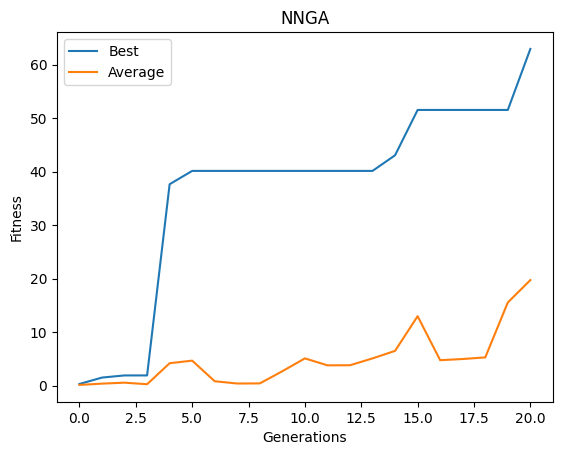

In [28]:
ag.plot_stats("NNGA")

In [29]:
ag.world.watch()

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

In [32]:
ag.fitness(
    ag.bestEver, 
    real_time=False, 
    show=True, 
    seconds=360,
)

Using random seed: 5010696


  0%|          | 0/3600 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.10; speed 57.24 x real time


0

: 